In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F

# Decoy MNIST Lab

## Load data (TODO: host online)

In [112]:
cache = np.load('./decoy-mnist.npz')
X, y, Xv, yv, Xt, yt = [cache[f] for f in sorted(cache.files)]

## TODO: visualize the decoy MNIST dataset and explain what's going on

## Define NN class & plotting methods

In [104]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 50) 
        self.fc2 = nn.Linear(50, 30)  
        self.fc3 = nn.Linear(30, 10)  
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
      
    def predict(self, x):
        images = torch.Tensor(x)
        logits = self(images)
        return np.argmax(logits.data.numpy(), axis=1)
      
    def input_grads(self, x):
        images = Variable(torch.Tensor(x), requires_grad=True)
        logits = self(images)
        logprobs = nn.functional.log_softmax(logits, 1)
        logprobs.sum().backward()
        return images.grad.data.numpy()
      
def one_hot(y):
    values = np.arange(10)
    return np.array([values == v for v in y]).astype(int)
  
def plot_grad(x):
    lim = np.abs(x).max()
    plt.imshow(x.reshape(-28,28), cmap='bwr', vmin=-lim, vmax=lim)
    plt.xticks([])
    plt.yticks([])

def plot_digit(x):
    lim = np.abs(x).max()
    plt.imshow(x.reshape(-28,28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

## Train network on training data

In [91]:
net = SimpleNeuralNetwork()
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  

In [92]:
training_loader = data.DataLoader(
    data.TensorDataset(
        torch.Tensor(X),
        torch.Tensor(one_hot(y))
    ),
    batch_size=256,
    shuffle=True
)

In [93]:
for epoch in range(10):
    for i, (images, labels) in enumerate(training_loader):  
        images = Variable(images.view(-1, 28*28))#.cuda()
        labels = Variable(labels)#.cuda()
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
    print('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.data)) 

Epoch 1, Loss: 0.0324
Epoch 2, Loss: 0.0547
Epoch 3, Loss: 0.0270
Epoch 4, Loss: 0.0264
Epoch 5, Loss: 0.0274
Epoch 6, Loss: 0.0140
Epoch 7, Loss: 0.0114
Epoch 8, Loss: 0.0168
Epoch 9, Loss: 0.0087
Epoch 10, Loss: 0.0137


## Examine validation and test accuracy

In [96]:
print("Validation accuracy:", (net.predict(Xv) == yv).mean())

Validation accuracy: 0.9702


In [97]:
print("Test accuracy:", (net.predict(Xt) == yt).mean())

Test accuracy: 0.7327


Hmm... something seems to be amiss! Let's look at the model's saliency maps:

In [98]:
grads = net.input_grads(Xt)

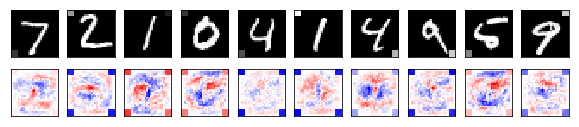

In [105]:
plt.figure(figsize=(10,2))
for i in range(10):
  plt.subplot(2,10,i+1)
  plot_digit(Xt[i])
for i in range(10):
  plt.subplot(2,10,i+11)
  plot_grad(grads[i])

A lot of the focus seems to be on the corners!

## Train a second model, this time on the test set!

In [113]:
net2 = SimpleNeuralNetwork()
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.001, weight_decay=0.01)  

In [114]:
test_loader = data.DataLoader(
    data.TensorDataset(
        torch.Tensor(Xt),
        torch.Tensor(one_hot(yt))
    ),
    batch_size=256,
    shuffle=True
)

In [115]:
for epoch in range(20):
    for i, (images, labels) in enumerate(test_loader):  
        images = Variable(images.view(-1, 28*28))#.cuda()
        labels = Variable(labels)#.cuda()
        optimizer2.zero_grad()
        outputs = net2(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer2.step()
    print('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.data)) 

Epoch 1, Loss: 0.1945
Epoch 2, Loss: 0.1077
Epoch 3, Loss: 0.0878
Epoch 4, Loss: 0.0372
Epoch 5, Loss: 0.0532
Epoch 6, Loss: 0.0994
Epoch 7, Loss: 0.0459
Epoch 8, Loss: 0.0250
Epoch 9, Loss: 0.0448
Epoch 10, Loss: 0.0112
Epoch 11, Loss: 0.0719
Epoch 12, Loss: 0.0470
Epoch 13, Loss: 0.0132
Epoch 14, Loss: 0.0686
Epoch 15, Loss: 0.0320
Epoch 16, Loss: 0.0152
Epoch 17, Loss: 0.0107
Epoch 18, Loss: 0.0761
Epoch 19, Loss: 0.0658
Epoch 20, Loss: 0.0057


## Examine validation and test accuracy

In [120]:
print("Validation accuracy:", (net2.predict(Xv)==yv).mean())

Validation accuracy: 0.9239


In [124]:
print('"Test" accuracy:', (net2.predict(X)==y).mean())

"Test" accuracy: 0.92628


Aha, much more even!

## Look at its gradients:

In [118]:
grads2 = net2.input_grads(Xv)

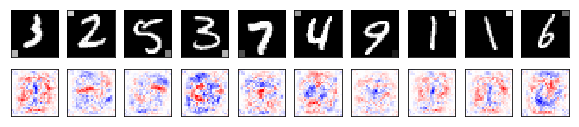

In [119]:
plt.figure(figsize=(10,2))
for i in range(10):
  plt.subplot(2,10,i+1)
  plot_digit(Xv[i])
for i in range(10):
  plt.subplot(2,10,i+11)
  plot_grad(grads2[i])

No corner splotches!